In [1]:
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
sys.path.insert(1, r'C:\Users\smartin5\Repos\myNeurochat')
#sys.path.insert(1, r'C:\Users\maolivei\neuro_sean\NeuroChaT')
%load_ext autoreload
%autoreload 2

In [2]:
from neurochat.nc_spike import NSpike
from neurochat.nc_spatial import NSpatial
from neurochat.nc_data import NData
from neurochat.nc_datacontainer import NDataContainer
import neurochat.nc_plot as nc_plot
import neurochat.nc_containeranalysis as nca
from neurochat.nc_clust import NClust
from neurochat.nc_utils import butter_filter
from neurochat.nc_utils import find_peaks

import numpy as np

In [3]:
# Setup the main data path
home = os.path.expanduser("~")
data_dir = os.path.join(
    home, "Recordings", "LCA1")
prepend_data_dir = lambda name : os.path.join(data_dir, name)

In [4]:
# Load the data
"""
spike_filenames = [
    "LCA1-linearpresleep30min050319.2",
    "050319D_LCA1_linear_10min.2",
    "LCA1-linearpresleep_40min050319_B.2"]
"""

spike_filenames = [
#    "LCA1-linearpresleep30min060319.2",
    "060319D_LCA1_linear_15min.2",
    "060319E_LCA1_linear_sleep_32min.2"]

spike_absolute_filenames = [prepend_data_dir(name) for name in spike_filenames]

spike_names = [
#    "pre-sleep",
    "run",
    "post-sleep"]

position_absolute_filenames = [f[:-2] + ".txt" for f in spike_absolute_filenames]

lfp_end = ".egf"

lfp_absolute_filenames = [f.split(".")[0] + lfp_end for f in spike_absolute_filenames]
print(lfp_absolute_filenames)

collection = NDataContainer(share_positions=False, load_on_fly=True)
collection.add_files(
    NDataContainer.EFileType.Spike, (spike_absolute_filenames, spike_names, None))
collection.add_files(
    NDataContainer.EFileType.LFP, lfp_absolute_filenames
)
collection.add_files(
    NDataContainer.EFileType.Position, position_absolute_filenames)

collection.setup()

['C:\\Users\\smartin5\\Recordings\\LCA1\\060319D_LCA1_linear_15min.egf', 'C:\\Users\\smartin5\\Recordings\\LCA1\\060319E_LCA1_linear_sleep_32min.egf']


In [5]:
# Setup the appropriate units
#collection.list_all_units()
# collection.set_units(["all", "all"])
run_units = [3, 2, 4] # top, middle, bottom is 2, 3, 4
sleep_units = [2, 3, 4, 6, 7, 8] # Units from powerpoint file
collection.set_units([run_units, sleep_units])

In [12]:
results = nca.replay(
    collection, 0, 1, match_clusters=True, mua_bin_length=1, 
    filter_length=0.01, mua_mode="raw", filter_mua=False, mua_length=1)

Best assignment is {2: (4, 0.9669052702547892), 3: (8, 0.9903904138800321), 4: (7, 0.9516436207398975)}


c:\users\smartin5\appdata\local\programs\python\python37\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


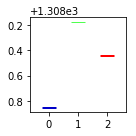

In [13]:
sleep_times = [
    nca.spike_times(collection.subsample(1), ranges=[i_range]) for 
    i_range in results["overlap swr mua"]
    ]
fig = nc_plot.plot_replay_sections(results, sleep_times)

In [14]:
print(sleep_times)

[[[1308.8468958333333, 1308.8508541666667], [1308.1747916666666], [1308.4406875, 1308.4485833333333]]]


In [15]:
print(results["overlap swr mua"])

[(1308.062512820513, 1309.062512820513)]


In [ ]:
fig = nc_plot.replay_summary(results)
plt.savefig("Nice_out.png")

# Below this point is extra stuff - not needed

In [ ]:
print(results.keys())

In [ ]:
# Spectrum plot
graph_data = collection.get_data(1).lfp.spectrum(
    window = 0.4, noverlap = 0.04, nfft = 2048, ptype = 'psd', 
    prefilt = True, filtset = [10, 100, 'highpass'], 
    fmax = 2400, db = False, tr = False, slice=slice(0, 9600, 1))
fig = nc_plot.lfp_spectrum(graph_data)

In [ ]:
# Example that is not needed
mua_res = nca.multi_unit_activity(collection.subsample(1), time_range=(1000, 1800), strip=True,
                             mua_bin_length=0.001, filter_length=0.010, filter_mua=True,
                             mua_percentile=0.99)

In [ ]:
# Displaying the filtered data
fs = collection.get_data(1).lfp.get_sampling_rate()
sample_start = int((924.4 * 4800))
sample_end = sample_start + 1200
lfp_samples = collection.get_data(1).get_samples()[sample_start:sample_end]
time = collection.get_data(1).lfp.get_timestamp()
filtered_lfp = butter_filter(lfp_samples, fs, 10, 100, 240, 'bandpass') # SWR
rms_data = window_rms(filtered_lfp, 33, "same")
ax, fig = nc_plot._make_ax_if_none(None)
ax.plot(time[sample_start:sample_end], filtered_lfp, color='r')
ax.plot(time[sample_start:sample_end], lfp_samples, color='b')
ax.plot(time[sample_start:sample_end], rms_data, color='g')